The cv2 module is part of OpenCV (Open Source Computer Vision Library), a popular library for image processing, computer vision, and machine learning tasks

This is an image processing simulation which splits an image into smaller images and then recombines all the 
smaller images together to reproduce the larger image

In [1]:
import cv2
import numpy as np
import os

def save_tile(tile, row, col, pad_h,pad_w,output_dir="tiles_npz"):
    """Embeds row and col indices into the tile and saves it as a .npz file."""
    extra_info_position = np.full((1, tile.shape[1], 3), [row, col, 0], dtype=np.uint8)
    padding_info = np.full((1,tile.shape[1],3),[pad_h,pad_w,0],dtype=np.uint8)
    tile_with_info = np.vstack((tile, extra_info_position))
    final_tile= np.vstack((tile_with_info,padding_info))

    os.makedirs(output_dir, exist_ok=True)
    np.savez(os.path.join(output_dir, f"tile_{row}_{col}.npz"), tile=final_tile)

def split_image(image, tile_size=64, output_dir="tiles_npz"):
    """Splits an image into tiles and embeds row/col metadata inside each tile."""
    os.makedirs(output_dir, exist_ok=True)

    img_h, img_w, _ = image.shape
    pad_h = (tile_size - (img_h % tile_size)) % tile_size
    pad_w = (tile_size - (img_w % tile_size)) % tile_size
    image_padded = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    padded_h, padded_w, _ = image_padded.shape
    rows, cols = padded_h // tile_size, padded_w // tile_size

    for i in range(rows):
        for j in range(cols):
            tile = image_padded[i * tile_size:(i + 1) * tile_size, j * tile_size:(j + 1) * tile_size]
            save_tile(tile, i, j,pad_h,pad_w ,output_dir)

    return rows, cols, pad_h, pad_w

# Load and split the image
image_path = "images.jpeg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

rows, cols, pad_h, pad_w = split_image(image, tile_size=64, output_dir="tiles_npz")
print(f"Tiles saved as .npz files. Grid size: {rows}x{cols}.")


Tiles saved as .npz files. Grid size: 3x5.


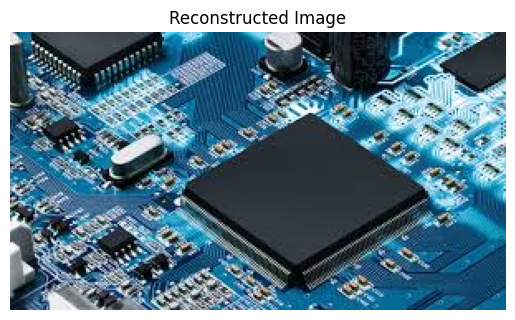

Reconstructed image saved as reconstructed_image.png


In [2]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

def load_tiles_npz(input_dir="tiles_npz"):
    """Loads all .npz tile files, extracts tile arrays, removes metadata, and sorts them based on row and column indices."""
    tile_files = sorted([f for f in os.listdir(input_dir) if f.endswith(".npz")])
    tiles = {}

    for file in tile_files:
        file_path = os.path.join(input_dir, file)
        data = np.load(file_path)

        tile_with_info = data["tile"]

        # Extract row and column from last row
        tiledata = tile_with_info[-2, 0, :]  # Extract from the last row and first column
        positiondata= tile_with_info[-1,0,:]
        row, col = int(tiledata[0]), int(tiledata[1])
        
        pad_h = positiondata[0]
        pad_w= positiondata[1]
        
        

       
        tile = tile_with_info[:-2]

        tiles[(row, col)] = tile  

    total_rows = max(row for row, _ in tiles.keys()) + 1
    total_cols = max(col for _, col in tiles.keys()) + 1

    return tiles, total_rows, total_cols,pad_h,pad_w

def reconstruct_image(tiles, total_rows, total_cols,pad_h,pad_w):
    """Reconstructs the original image by stitching tiles together."""
    try:
        stitched_rows = [np.hstack([tiles[(i, j)] for j in range(total_cols)]) for i in range(total_rows)]
        stitched_image = np.vstack(stitched_rows)  # Stitch columns
    except KeyError as e:
        print(f"Error: Missing tile at {e}. Check your saved tiles.")
        return None

    return stitched_image

# Load tiles and metadata from .npz files
tiles, total_rows, total_cols,pad_h,pad_w = load_tiles_npz(input_dir="tiles_npz")

# Reconstruct the image
stitched_image = reconstruct_image(tiles, total_rows, total_cols,pad_h,pad_w)
stitched_image = stitched_image[:stitched_image.shape[0] - pad_h, :stitched_image.shape[1] - pad_w]



if stitched_image is not None:
    # Save the reconstructed image
    reconstructed_path = "reconstructed_image.png"

    cv2.imwrite(reconstructed_path, cv2.cvtColor(stitched_image, cv2.COLOR_RGB2BGR))

    # Display the reconstructed image
    plt.imshow(stitched_image)
    plt.title("Reconstructed Image")
    plt.axis("off")
    plt.show()

    print(f"Reconstructed image saved as {reconstructed_path}")
